In [67]:
import matplotlib.pyplot as plot
import numpy as np
import os
import pandas as pd
import pandas.io.json as pj
import psycopg2
from statsmodels.tsa.api import ExponentialSmoothing

In [68]:
def load_query(query):
    conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR'))
    samples = pd.read_sql_query(query, conn)
    conn.close()
    return samples

Y-axis format function from https://stackoverflow.com/a/40573071

In [69]:
from matplotlib.ticker import FuncFormatter

def format_bytes(y, pos):
    decades = [1e12, 1e9, 1e6, 1e3, 1e0]
    suffix  = ["TB", "GB", "MB", "kB", "B"]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])
    return y

def format_exp(y, pos):
    decades = [1e12, 1e9, 1e6, 1e3, 1e0]
    suffix  = ["T", "B", "M", "K", ""]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])
    return y

In [70]:
chunk_rows_raw = load_query("""
SELECT
  SUM(n_live_tup) AS value,
  to_timestamp(lower(ranges[1])/10^6) AS time
FROM chunk_relation_size('metric_samples') AS m
JOIN pg_stat_user_tables AS t
  ON CONCAT(t.schemaname, '.', t.relname) = m.chunk_table
GROUP BY time
ORDER BY time;
""")
print(chunk_rows_raw.head(5))

   value                      time
0    0.0 2019-12-10 12:00:00+00:00
1    0.0 2019-12-10 13:00:00+00:00
2    0.0 2019-12-10 14:00:00+00:00
3    0.0 2019-12-10 15:00:00+00:00
4    0.0 2019-12-10 16:00:00+00:00


In [71]:
chunk_rows = chunk_rows_raw.set_index('time').resample('1h').max()
print(chunk_rows.head(2))

                           value
time                            
2019-12-10 12:00:00+00:00    0.0
2019-12-10 13:00:00+00:00    0.0


In [72]:
chunk_size_raw = load_query("""
SELECT
    MAX(table_name) AS metric,
    to_timestamp(lower(ranges[1])/10^6) AS time,
    SUM(total_bytes)
FROM _timescaledb_catalog.hypertable, chunk_relation_size(table_name::text)
WHERE hypertable.table_name LIKE 'metric%' 
GROUP BY time ORDER BY 1, 2;
""")
print(chunk_size_raw.head(5))

           metric                      time      sum
0  metric_samples 2019-12-10 12:00:00+00:00  32768.0
1  metric_samples 2019-12-10 13:00:00+00:00  32768.0
2  metric_samples 2019-12-10 14:00:00+00:00  32768.0
3  metric_samples 2019-12-10 15:00:00+00:00  32768.0
4  metric_samples 2019-12-10 16:00:00+00:00  32768.0


In [73]:
chunk_size = pd.pivot(chunk_size_raw, index='time', columns='metric', values='sum').resample('1h').max()
print(chunk_size.head(2))

metric                     metric_samples
time                                     
2019-12-10 12:00:00+00:00         32768.0
2019-12-10 13:00:00+00:00         32768.0


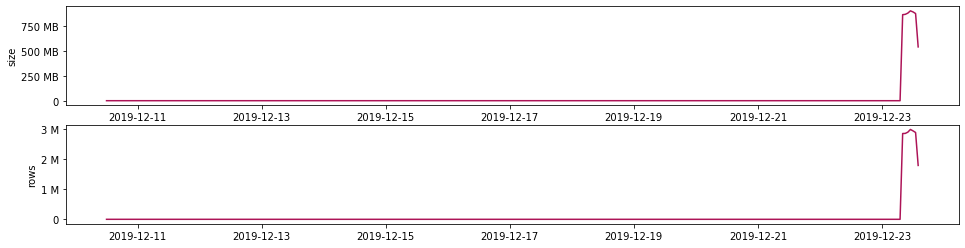

In [80]:
%matplotlib inline
palette_key = '#AD1457'

fig, ax = plot.subplots(nrows=2, figsize=(16, 4))

ax[0].plot(chunk_size, color=palette_key)
ax[0].yaxis.set_major_formatter(FuncFormatter(format_bytes))
ax[0].yaxis.set_label_text('size')

ax[1].plot(chunk_rows, color=palette_key)
ax[1].yaxis.set_major_formatter(FuncFormatter(format_exp))
ax[1].yaxis.set_label_text('rows')

fig.show()